In [35]:
import pandas as pd
import urllib.request
import numpy as np
from IPython.display import display
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support


In [3]:
print('Loading case data ...')
cases = pd.read_csv("pancancer_case_features.csv")
print("done.")

Loading case data ...
done.


In [4]:
labels_string = cases.cancer_type
le = preprocessing.LabelEncoder()
labels = le.fit_transform(labels_string)


# Get rid of the cancer type and patient_id columns 
data = cases[cases.columns[3:]]

display(labels)
display(data.head())

array([ 8,  8,  8, ..., 28,  4,  3])

,A1CF,A2M,A2ML1,AADACL4,AASS,ABCA1,ABCA12,ABCA13,ABCA2,ABCA3,...,ZSCAN2,ZSCAN20,ZSCAN21,ZSCAN29,ZSWIM8,ZW10,ZXDB,ZYG11B,ZYX,ZZEF1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#skf = StratifiedKFold(n_splits=10)
#for train_index, test_index in skf.split(data, labels):
#    train_data, test_data     = data.values[train_index], data.values[test_index]
#    train_labels, test_labels = labels[train_index], labels[test_index]
#    print(len(train_data), len(test_data))
    



8994 1014
8998 1010
9001 1007
9003 1005
9005 1003
9007 1001
9011 997
9016 992
9016 992
9021 987


In [19]:
train_data_all, test_data, train_labels_all, test_labels = train_test_split(data, labels,
                                                           stratify=labels, 
                                                           test_size=0.25)

train_data, dev_data, train_labels, dev_labels = train_test_split(train_data_all, train_labels_all,
                                                                 stratify=train_labels_all, 
                                                                 test_size=0.20)

print("training data:", train_data.shape)
print("dev data     :", dev_data.shape)
print("test data    :",  test_data.shape)



training data: (6004, 4778)
dev data     : (1502, 4778)
test data    : (2502, 4778)


In [20]:



#
# Multinomial Naive Bayes
#
mnb = MultinomialNB()
params = {'alpha': [0.001, 0.01, 0.1, 0.5, 1, 10]}
mnb = GridSearchCV(mnb, params, cv=5,
                               scoring='accuracy', return_train_score=True)
# Fit  training data
mnb.fit(train_data, train_labels)  
# Show the best alpha parameter to use and the expected accuracy
print('\nMultinomial Naive Bayes Classifier')
print(' Best param:',   mnb.best_params_)
print(' Accuracy:  ',   np.round(mnb.best_score_, 4) )


#
# Logistic Regression
#
lr = LogisticRegression(penalty='l2', multi_class = 'ovr', solver='liblinear', max_iter=150)
params = {'C': [0.001, 0.01, 0.1, 0.5, 1, 10]}
logit = GridSearchCV(lr, params, cv=5,
                     scoring='accuracy', return_train_score=True)

# Fit  training data
logit.fit(train_data, train_labels)  
# Show the best C parameter to use and the expected accuracy
print('\nLogistic Regression Classifier, L2 regularization')
print(' Best param:', logit.best_params_)
print(' Accuracy:  ', np.round(logit.best_score_, 4) )







Multinomial Naive Bayes Classifier
 Best param: {'alpha': 1}
 Accuracy:   0.4082
Logistic Regression Classifier
 Best param: {'C': 0.1}
 Accuracy:   0.5183


In [48]:
def runLogitL1(train_data, train_labels, dev_data, dev_labels, c_param):
    l1 = LogisticRegression(penalty='l1', tol=.01, 
                            solver="liblinear", multi_class="ovr",
                            max_iter=500, C=c_param)
    # Fit model
    l1.fit(train_data, train_labels) 
    # Predict
    predict = l1.predict(dev_data)
    # Get precision, recall, f1 scores
    scores = precision_recall_fscore_support(dev_labels, predict, average='weighted', labels=np.unique(predict))  
    
    # Get the features with non-zero coefficients.  We will use
    # this list to reduce the features for the
    # following logistic regression with L2 regularization
    non_zero_sums = np.where(np.sum(l1.coef_, axis=0) != 0)
    names = np.array(list(train_data.columns))
    non_zero_names = names[non_zero_sums] 
    
    return {'scores': scores, 'non_zero_genes': non_zero_names}

from textwrap import wrap
params = {'C':  [1000, 100, 10, 1, .5, .3, .1, .05]}


# Now perform logistic regression on this training set with reduced features
# as well as the orginal non-reduced training set.  Run over different
# C values to plot differences in accuracy
precision_l1        = []
recall_l1           = []
precision_l2      = []
recall_l2           = []
feature_size        = []


for c_param in reversed(params['C']):
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    #
    # Perform Logistic Regression on different C values
    # using L1 regularization
    #
    l1_info = runLogitL1(train_data, train_labels, dev_data, dev_labels, c_param)    
    non_zero_genes = l1_info['non_zero_genes']
    feature_size.append(str(len(non_zero_genes)) + ' (C=' + str(c_param) + ")")
    precision_l1.append(l1_info['scores'][0])
    recall_l1.append(l1_info['scores'][1])


    #
    # Reduce feature size, only keeping features with non-zero weights 
    # found using l1 regularization
    #
    min_train_data = train_data[non_zero_genes]
    min_dev_data   = dev_data[non_zero_genes]


    # Run logistic regression with L2 regularization on reduced
    # feature set
    lr = LogisticRegression(penalty='l2', tol=.01, max_iter=150, 
                            C=logit.best_params_['C'], solver="liblinear", multi_class="ovr")
    lr.fit(min_train_data, train_labels) 

    predict = lr.predict(min_dev_data)
    
    # Get precision, recall, f1 scores
    scores = precision_recall_fscore_support(dev_labels, predict, average='weighted', labels=np.unique(predict))  
    precision_l2.append(scores[0])
    recall_l2.append(scores[1])






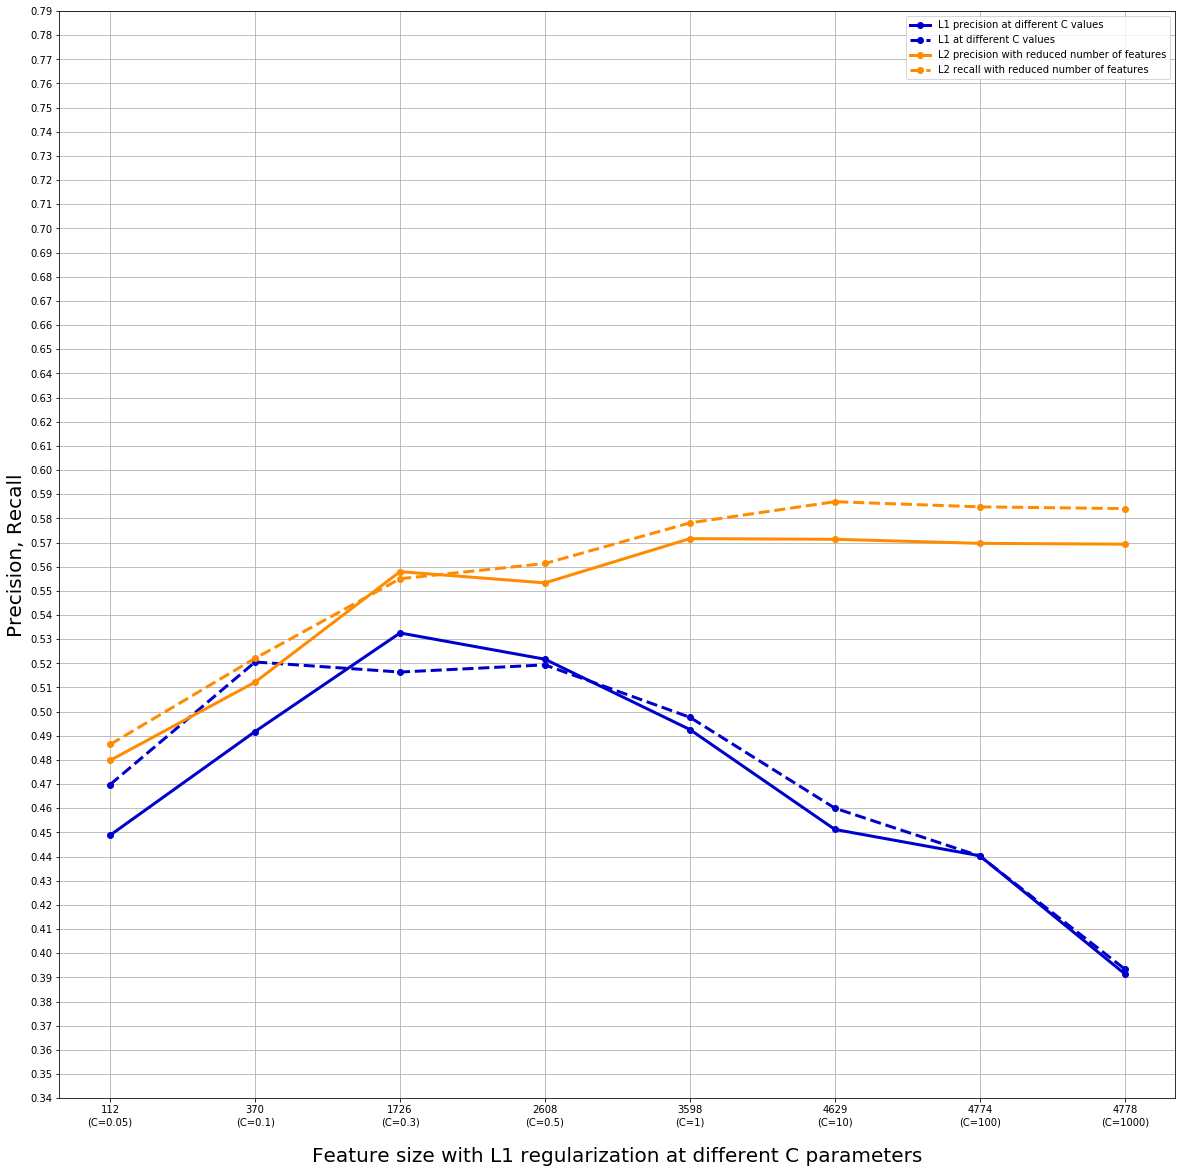

In [49]:

labels = [ '\n'.join(wrap(l, 8)) for l in feature_size ]        
plt.rcParams["figure.figsize"] = (20,20)
plt.plot(labels, precision_l1, color='mediumblue',
         linewidth=3, label='L1 precision at different C values', marker='o' )
plt.plot(labels, recall_l1, color='mediumblue', linestyle='dashed',
         linewidth=3, label='L1 at different C values', marker='o' )

plt.plot(labels, precision_l2, color='darkorange', 
         linewidth=3, label='L2 precision with reduced number of features', marker='o' )
plt.plot(labels, recall_l2, color='darkorange', linestyle='dashed',
         linewidth=3, label='L2 recall with reduced number of features', marker='o' )

plt.yticks(np.arange(.34, .8, .01))
plt.ylabel('Precision, Recall', fontsize=20)
plt.xlabel('Feature size with L1 regularization at different C parameters', fontsize=20, labelpad=20)
plt.legend()
plt.grid()
plt.show()
        